In [2]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') # use multilingual models for texts with non-english characters


ModuleNotFoundError: No module named 'sentence_transformers'

In [2]:
# Single list of sentences
sentences = ['Korting op waterspeelgoed',
             'Tot 180,- retour op de Samsung Galaxy S23-serie',
             'Weer in het ritme komen van schrift tot stift',
             'Réduction sur les jouets aquatiques',
              'Jusqu\'à 180,- remboursés sur la série Samsung Galaxy S23',
              'Reprenez le travail des stylos aux cahiers',
              'Hoge Select-korting op JBL en Harman Kardon',
              'Remise Select importante sur JBL et Harman Kardon',
              'Korting op LEGO Technic voertuigen',
              'Réduction sur LEGO Véhicules Technic',
              'Grosse réduction sur les toppers LEGO Friends',
              'Hoge korting op LEGO Friends toppers']

#Compute embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.cos_sim(embeddings, embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in pairs[0:15]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], pair['score']))

Tot 180,- retour op de Samsung Galaxy S23-serie 		 Jusqu'à 180,- remboursés sur la série Samsung Galaxy S23 		 Score: 0.9580
Grosse réduction sur les toppers LEGO Friends 		 Hoge korting op LEGO Friends toppers 		 Score: 0.9393
Korting op waterspeelgoed 		 Réduction sur les jouets aquatiques 		 Score: 0.8510
Korting op LEGO Technic voertuigen 		 Réduction sur LEGO Véhicules Technic 		 Score: 0.7878
Hoge Select-korting op JBL en Harman Kardon 		 Remise Select importante sur JBL et Harman Kardon 		 Score: 0.7798
Korting op LEGO Technic voertuigen 		 Grosse réduction sur les toppers LEGO Friends 		 Score: 0.7372
Réduction sur LEGO Véhicules Technic 		 Grosse réduction sur les toppers LEGO Friends 		 Score: 0.7034
Korting op LEGO Technic voertuigen 		 Hoge korting op LEGO Friends toppers 		 Score: 0.6892
Weer in het ritme komen van schrift tot stift 		 Reprenez le travail des stylos aux cahiers 		 Score: 0.6467
Réduction sur LEGO Véhicules Technic 		 Hoge korting op LEGO Friends toppers 		

In [3]:
"""
The pre-trained models produce embeddings of size 512 - 1024. However, when storing a large
number of embeddings, this requires quite a lot of memory / storage.

In this example, we reduce the dimensionality of the embeddings to e.g. 128 dimensions. This significantly
reduces the required memory / storage while maintaining nearly the same performance.

For dimensionality reduction, we compute embeddings for a large set of (representative) sentence. Then,
we use PCA to find e.g. 128 principle components of our vector space. This allows us to maintain
us much information as possible with only 128 dimensions.

PCA gives us a matrix that down-projects vectors to 128 dimensions. We use this matrix
and extend our original SentenceTransformer model with this linear downproject. Hence,
the new SentenceTransformer model will produce directly embeddings with 128 dimensions
without further changes needed.
"""
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer, LoggingHandler, util, evaluation, models, InputExample
import logging
import os
import gzip
import csv
import random
import numpy as np
import torch


#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout

#Model for which we apply dimensionality reduction
#model = SentenceTransformer('all-MiniLM-L6-v2')

#New size for the embeddings
new_dimension = 32


#We use AllNLI as a source of sentences to compute PCA
nli_dataset_path = 'datasets/AllNLI.tsv.gz'

#We use the STS benchmark dataset to see how much performance we loose by using the dimensionality reduction
sts_dataset_path = 'datasets/stsbenchmark.tsv.gz'

if not os.path.exists(nli_dataset_path):
    util.http_get('https://sbert.net/datasets/AllNLI.tsv.gz', nli_dataset_path)

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)


# We measure the performance of the original model
# and later we will measure the performance with the reduces dimension size
logger.info("Read STSbenchmark test dataset")
eval_examples = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['split'] == 'test':
            score = float(row['score']) / 5.0 #Normalize score to range 0 ... 1
            eval_examples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

# Evaluate the original model on the STS benchmark dataset
stsb_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, name='sts-benchmark-test')

logger.info("Original model performance:")
stsb_evaluator(model)

######## Reduce the embedding dimensions ########

#Read sentences from NLI dataset
nli_sentences = set()
with gzip.open(nli_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        nli_sentences.add(row['sentence1'])
        nli_sentences.add(row['sentence2'])

nli_sentences = list(nli_sentences)
random.shuffle(nli_sentences)

import pathlib

files = [f for f in pathlib.Path("/Users/seng1/Documents/bol/treatments/").iterdir() if f.is_file()]
df = pd.DataFrame()
for f in files:
    df = pd.concat([df, pd.read_csv(f.resolve(), delimiter=";")], ignore_index=True)

df.fillna('', inplace=True)
df.drop_duplicates(subset=['pyName'], inplace=True)
df['TextData'] = (df['Title'].map(str) + " " + df['SubTitle'].map(str))
df['TextData'] = df['TextData'].str.strip()
df= df.dropna(subset = ['TextData'])

sentences = df['TextData'].unique().tolist()

random.shuffle(sentences)

#To determine the PCA matrix, we need some example sentence embeddings.
#Here, we compute the embeddings for 20k random sentences from the AllNLI dataset
pca_train_sentences = sentences#nli_sentences[0:20000]
#pca_train_sentences.append(sentences)
train_embeddings = model.encode(pca_train_sentences, convert_to_numpy=True)

#Compute PCA on the train embeddings matrix
pca = PCA(n_components=new_dimension)
pca.fit(train_embeddings)
pca_comp = np.asarray(pca.components_)

# We add a dense layer to the model, so that it will produce directly embeddings with the new size
dense = models.Dense(in_features=model.get_sentence_embedding_dimension(), out_features=new_dimension, bias=False, activation_function=torch.nn.Identity())
dense.linear.weight = torch.nn.Parameter(torch.tensor(pca_comp))
model.add_module('dense', dense)

# Evaluate the model with the reduce embedding size
logger.info("Model with {} dimensions:".format(new_dimension))
stsb_evaluator(model)


# If you like, you can store the model on disc by uncommenting the following line
model.save('models/MiniLM-'+str(new_dimension)+'dim-model')

# You can then load the adapted model that produces new dimensional embeddings like this:
#model = SentenceTransformer('models/MiniLM-'+str(new_dimension)+'dim-model')


2023-09-07 23:30:19 - Read STSbenchmark test dataset
2023-09-07 23:30:19 - Original model performance:
2023-09-07 23:30:19 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-benchmark-test dataset:
2023-09-07 23:30:31 - Cosine-Similarity :	Pearson: 0.8342	Spearman: 0.8442
2023-09-07 23:30:31 - Manhattan-Distance:	Pearson: 0.8361	Spearman: 0.8379
2023-09-07 23:30:31 - Euclidean-Distance:	Pearson: 0.8358	Spearman: 0.8374
2023-09-07 23:30:31 - Dot-Product-Similarity:	Pearson: 0.7035	Spearman: 0.6981


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

2023-09-07 23:30:53 - Model with 32 dimensions:
2023-09-07 23:30:53 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-benchmark-test dataset:
2023-09-07 23:31:06 - Cosine-Similarity :	Pearson: 0.7818	Spearman: 0.7996
2023-09-07 23:31:06 - Manhattan-Distance:	Pearson: 0.7773	Spearman: 0.7843
2023-09-07 23:31:06 - Euclidean-Distance:	Pearson: 0.7799	Spearman: 0.7879
2023-09-07 23:31:06 - Dot-Product-Similarity:	Pearson: 0.4953	Spearman: 0.5302
2023-09-07 23:31:06 - Save model to models/MiniLM-32dim-model


In [14]:

#Compute embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.cos_sim(embeddings[0:200], embeddings[0:200])

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in pairs[0:15]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], pair['score']))

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

20% korting* op alles van Etos 		 Tot 20% korting* op Etos assortiment 		 Score: 0.9425
Alléén vandaag korting op apparaten van Bosch 		 Seulement aujourd'hui rabais élevé sur Bosch 		 Score: 0.9419
Jongerendeal tot 50% korting, o.a dameskleding 		 Stijlvolle dameskleding tot 40% korting* 		 Score: 0.9407
Jusqu'à 25 % de réduction sur les soins capillaires professionnels 		 Jusqu'à 40 % de réduction sur les soins bucco-dentaires 		 Score: 0.9371
Nieuwe collectie dameskleding 		 nouvelle collection vêtements pour hommes 		 Score: 0.9357
Wingardium leviosa… offre du jour sur Harry Potter! 		 Gourdes Harry Potter Aguamenti ! 		 Score: 0.9280
Stijlvolle dameskleding tot 40% korting* 		 Dagdeal tot 30% korting op herenkleding 		 Score: 0.9162
Goed geprijsde Macbook 		 Duuzame MacBooks bekijk het assortiment 		 Score: 0.9113
Housses de couette pour le printemps 		 Linge de lit Fris pour le printemps 		 Score: 0.9015
Jusqu'à 50 % de réduction* sur des articles pour bébés plus durables 		 Jusq

In [5]:
embeddings = model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print(embedding) # numpy.ndarray
    print(embeddings.shape)

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

[-1.1763123   0.9347257   0.8018496  -0.21468899  0.9326745   0.5651636
  0.5205086   1.3285878   0.1462086  -0.15357572 -0.00879671  0.22488225
 -0.38442913 -0.46433046  0.16272987  0.12134977  1.0694813   0.19803986
 -0.482299   -0.45494333 -0.3699971   0.1092418  -0.4220837   0.22351338
 -0.05504572  0.7381414  -0.4868216  -0.22253615 -0.36388373 -0.43492714
 -0.7482953  -0.55294126]
(3543, 32)
[-2.042993    0.60836285  0.59114015 -0.02539728 -0.64114124  0.6503741
  0.803832    0.46012324  0.30321783  0.57428235  0.41373548 -0.00828452
 -1.0769614   0.80525815  0.5588468   0.22222637  0.13409328  0.12034947
  0.02085127  0.00408315 -0.17307372 -0.21135855  0.33622646  0.1341848
  0.55357563  0.56435984 -0.03921753  0.04566779 -0.54717237 -0.53404665
  0.40543213 -0.21099736]
(3543, 32)
[ 0.34227878  0.590128   -0.00642852 -0.26966813 -0.26473168  0.11531854
  0.71613824  0.03272958  0.23143072 -0.16032813  0.46949756 -0.5552803
  0.18343186  0.5165798   0.28019625  0.19121528 -0.16

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

/Users/seng1/catboost/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Clusters identified visualized in 2d using t-SNE')

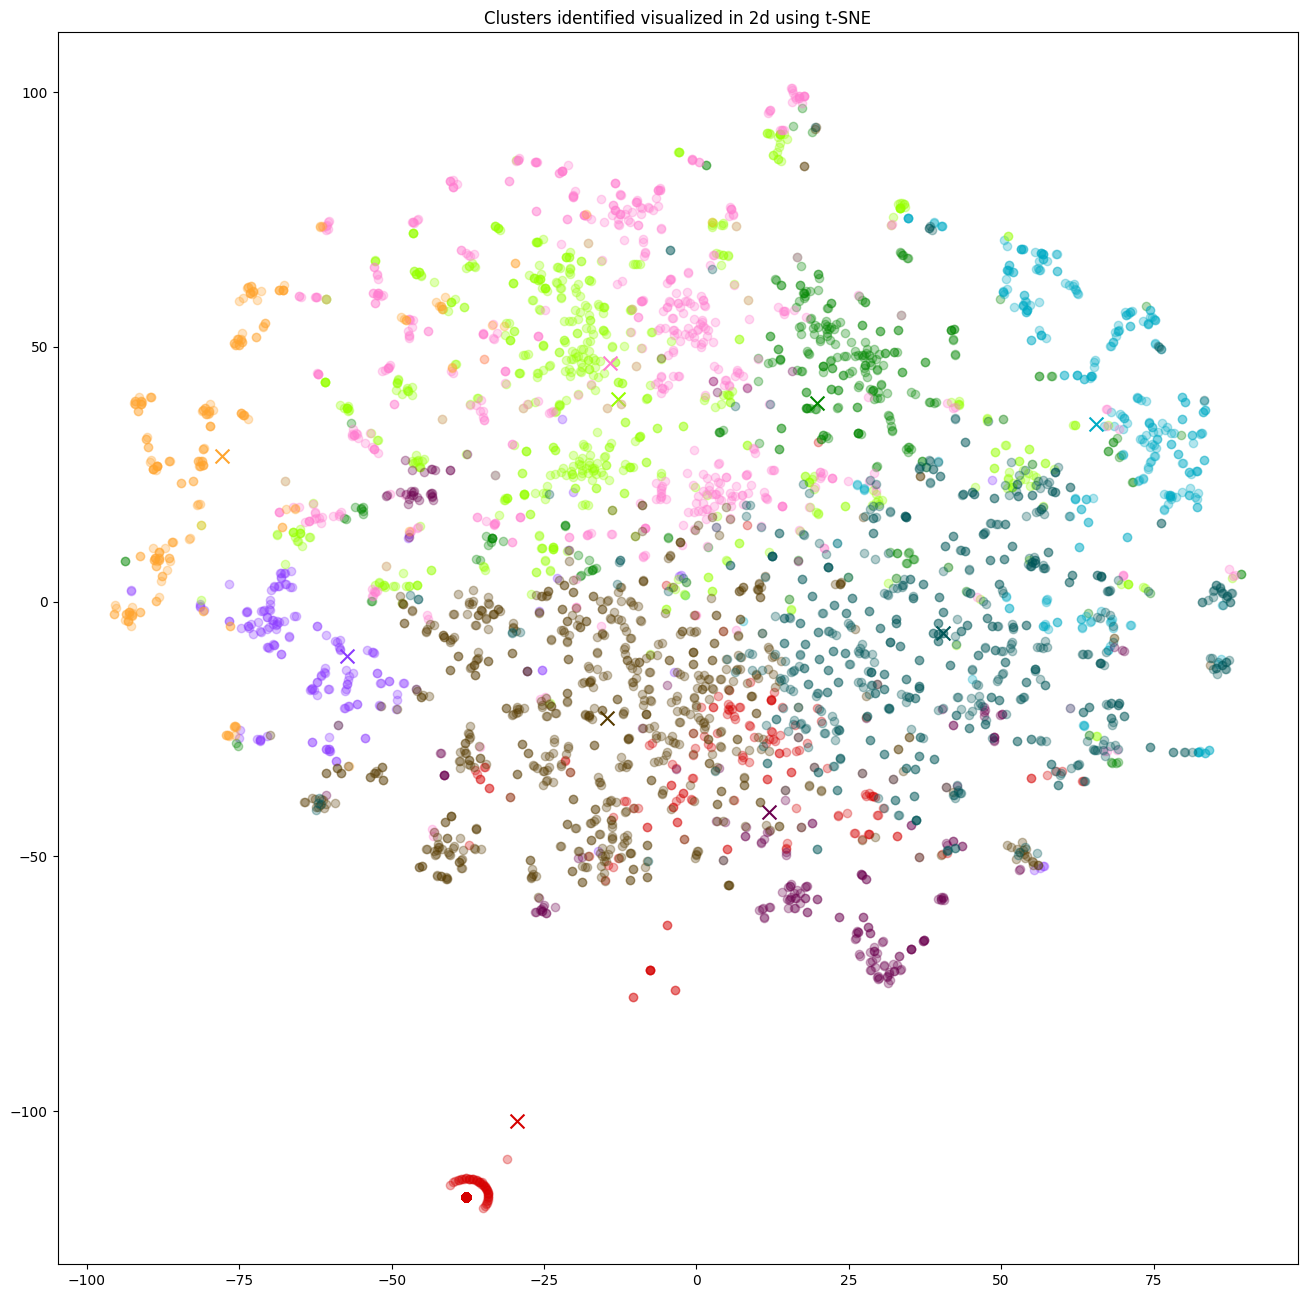

In [9]:
import colorcet as cc
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

n_clusters = 10

embeddings = model.encode(df['TextData'].tolist(), convert_to_tensor=True)
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_
df["Cluster"] = labels

palette = sns.color_palette(cc.glasbey, n_colors=n_clusters)

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embeddings)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

plt.figure(figsize=(16,16))
for category, color in enumerate(palette):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

plt.title("Clusters identified visualized in 2d using t-SNE")

In [11]:
embeddings = model.encode(sentences, convert_to_tensor=True)

df = pd.concat([pd.read_json("/Users/seng1/Downloads/NBA-SR_ActionTreatmentMetaDataExport_20230821T152325_GMT/data.json", lines = True), pd.read_csv("/Users/seng1/Downloads/ActionTreatmentMetaDataExport_20230421.csv")], ignore_index=True)
df = pd.concat([df, pd.read_json("/Users/seng1/Downloads/NBA-SR_ActionTreatmentMetaDataExport_20230824T211834_GMT/data.json", lines = True)], ignore_index=True)
df = pd.concat([df, pd.read_json("/Users/seng1/Downloads/NBA-SR_ActionTreatmentMetaDataExport_20230826T155123_GMT/data.json", lines = True)], ignore_index=True)
df = pd.concat([df, pd.read_csv("/Users/seng1/Downloads/ActionTreatmentMetaDataExport_20230421.csv")], ignore_index=True)

df['TextData'] = (df['Title'].map(str) + " " + df['SubTitle'].map(str))
df['TextData'] = df['TextData'].str.strip()
df.drop_duplicates(subset=['TextData'], inplace=True)
df.dropna(subset = ['TextData'], inplace=True)
df['ShelfLevel1'] = df['ShelfLevel1'].replace('',np.nan,regex = True)
df.dropna(subset = ['ShelfLevel1'], inplace=True)
df['ShelfLevel1'] = df['ShelfLevel1'].astype(int)

data = pd.DataFrame({'TextData': sentences, 'lower_dim_embeddings': embeddings.tolist()})
df=pd.merge(data, df, on='TextData')

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(np.array(df.lower_dim_embeddings.values.tolist()))
vis_dims.shape


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

(369, 2)

L1 shelves found: 21


Text(0.5, 1.0, 'Treatment call to actions groupped by product category level 1 and visualized using t-SNE')

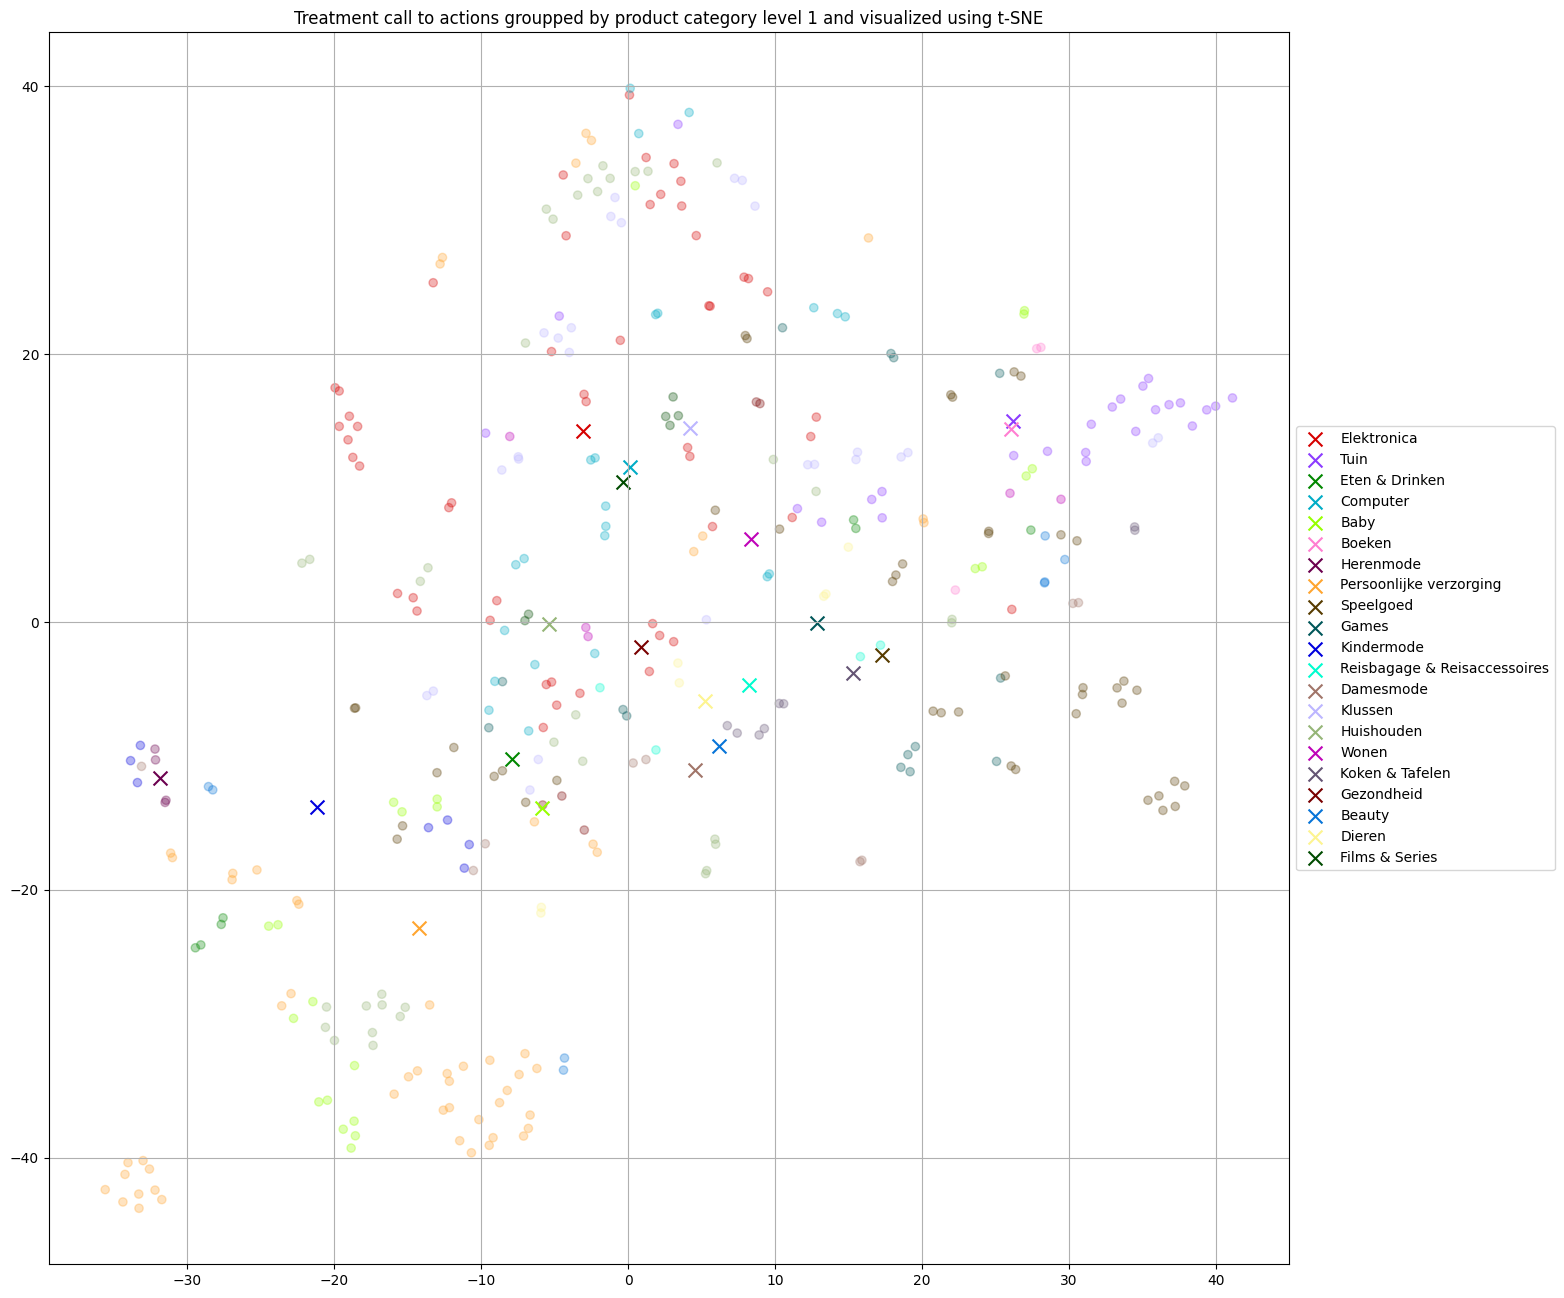

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import colorcet as cc
import seaborn as sns

shelfL1Num = df['ShelfLevel1'].unique().size
print("L1 shelves found: " + str(shelfL1Num))
df['L1ID'] = df.groupby(['ShelfLevel1'], sort=False).ngroup()

palette = sns.color_palette(cc.glasbey, n_colors=shelfL1Num)

x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.L1ID.values

plt.figure(figsize=(16,16))
colormap = matplotlib.colors.ListedColormap(palette)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for level in range(shelfL1Num):
    avg_x = np.array(x)[df.L1ID==level].mean()
    avg_y = np.array(y)[df.L1ID==level].mean()
    color = palette[level]
    levelName = df[df.L1ID==level].ShelfLevel1Name.min()
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100, label=levelName)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.title("Treatment call to actions groupped by product category level 1 and visualized using t-SNE")

In [6]:
import pandas as pd
df = pd.DataFrame()
#df = pd.concat([pd.read_json("/Users/seng1/Documents/bol/actions/NBA-SR_ActionTreatmentMetaDataExport_20230821T152325_GMT/data.json", lines = True), pd.read_csv("/Users/seng1/Downloads/ActionTreatmentMetaDataExport_20230421.csv")], ignore_index=True)
#df = pd.concat([df, pd.read_json("/Users/seng1/Documents/bol/actions/NBA-SR_ActionTreatmentMetaDataExport_20230824T211834_GMT/data.json", lines = True)], ignore_index=True)
df = pd.concat([df, pd.read_json("/Users/seng1/Documents/bol/actions/NBA-SR_ActionTreatmentMetaDataExport_20230826T155123_GMT/data.json", lines = True)], ignore_index=True)


In [2]:
df.columns

Index(['IsSMSEnabled', 'pySubjectType', 'pxInteractionID', 'IsOtherEnabled',
       'pyIsPropositionActive', 'pyDeliverOffline', 'pxDecisionReference',
       'SourceRuleSetVersion', 'StartDate', 'ShelfLevel1Name',
       'pySpecifyEmailSubject', 'pxIdentifier', 'pyChannel',
       'SourceRuleSetName', 'ShelfLevel2Name', 'pySubjectID', 'pyTreatment',
       'pyPreviousComponent', 'pyGroup', 'ShelvesL2List', 'IsPushEnabled',
       'pyApplicationVersion', 'pyComponent', 'pxRank', 'pyIssue',
       'IsAssistEnabled', 'AssociatedCategories', 'pxUpdateOpName',
       'pxUpdateOperator', 'ApplyAnalytics', 'pyTempDouble', 'pyApplication',
       'Language', 'pyInteraction', 'pyName', 'IsMobileEnabled',
       'FlexBannerID', 'pyTemplateName', 'Preheader', 'TreatmentKeyCode',
       'IsWebEnabled', 'pyEmailSubject', 'IsEmailEnabled', 'pyTemplateType',
       'RPGActionID', 'pyIsVolumeConstraintEnabled', 'ActionContext',
       'EndDate', 'IsDefaultBanner', 'pzADMInputSource', 'ShelfLevel2',
 

In [14]:
df[['pyName', "ShelfLevel1", 'ShelfLevel1Name', 'ShelvesL2List', 'pyIsPropositionActive']]

,pyName,ShelfLevel1,ShelfLevel1Name,ShelvesL2List,pyIsPropositionActive
0,CR247251,8299,Boeken,"24410,2551,2510,10756,2666",Date
1,CR247251,8299,Boeken,"24410,2551,2510,10756,2666",Date
2,CR244799,7934,Speelgoed,"10596,10550,54875",Date
3,CR244799,7934,Speelgoed,"10596,10550,54875",Date
4,CR240299,12001,Huishouden,"61599,31565,13167",Date
...,...,...,...,...,...
2899,CR254992,36080,Eten & Drinken,"15485,21822,47536,63487,64414",Date
2900,CR254992,36080,Eten & Drinken,"15485,21822,47536,63487,64414",Date
2901,XUpsellHair,,,50713,Date
2902,XUpsellChildrensBook,,,24421,Date


<Axes: xlabel='ShelfLevel1Name'>

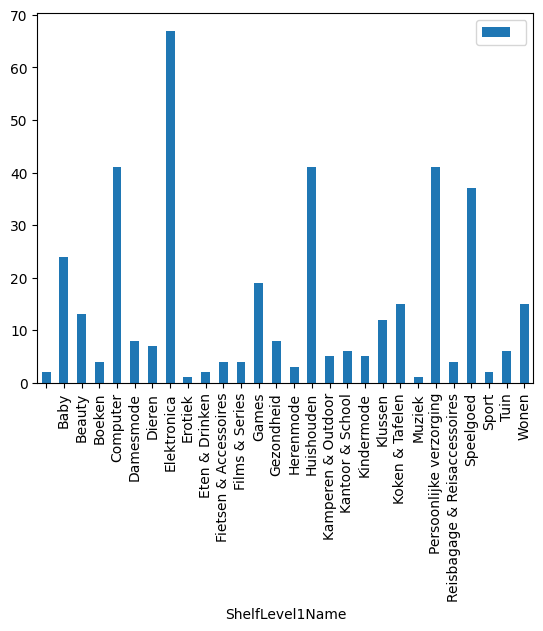

In [21]:
df.drop_duplicates(subset=['pyName'], keep='last').query('ShelvesL2List != ""').groupby('ShelfLevel1Name').size().plot(kind = 'bar', legend=True)